# Machine Learning Challenge 1-1

In [1]:
# !pip install kagglehub
# !pip install ipywidgets
# !pip install xgboost

## 匯入必要套件

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import kagglehub
from sklearn.utils import resample

# general setting. do not change TEST_SIZE
RANDOM_SEED = 42
TEST_SIZE = 0.3

## Load Dataset & Prepare Data

In [3]:
# load dataset（from kagglehub）
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
data = pd.read_csv(f"{path}/creditcard.csv")
data['Class'] = data['Class'].astype(int)

# prepare data
data = data.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

## Fraud/Non-Fraud Transactions

In [4]:
fraud = data[data['Class'] == 1]
nonfraud = data[data['Class'] == 0]
print(f'Fraudulent:{len(fraud)}, non-fraudulent:{len(nonfraud)}')
print(f'the positive class (frauds) percentage: {len(fraud)}/{len(fraud) + len(nonfraud)} ({len(fraud)/(len(fraud) + len(nonfraud))*100:.3f}%)')

Fraudulent:492, non-fraudulent:284315
the positive class (frauds) percentage: 492/284807 (0.173%)


## 監督式學習 (random forest)

In [5]:
# define evaluation function
def evaluation(y_true, y_pred, model_name="Model"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f'\n{model_name} Evaluation:')
    print('===' * 15)
    print('         Accuracy:', accuracy)
    print('  Precision Score:', precision)
    print('     Recall Score:', recall)
    print('         F1 Score:', f1)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

In [12]:
X = np.asarray(data.iloc[:, ~data.columns.isin(['Class'])])
Y = np.asarray(data.iloc[:, data.columns == 'Class'])

# split training set and data set
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

y_train = y_train.ravel()
y_test = y_test.ravel()

### Result of 監督式學習(random forest)

In [39]:
# build Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
rf_model.fit(x_train, y_train)

# predict and print result
y_pred = rf_model.predict(x_test)
# print(classification_report(y_test, y_pred))
evaluation(y_test, y_pred, model_name="Random Forest(Supervised)")


Random Forest(Supervised) Evaluation:
         Accuracy: 0.9996371850239341
  Precision Score: 0.9411764705882353
     Recall Score: 0.8235294117647058
         F1 Score: 0.8784313725490196

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.94      0.82      0.88       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443



## 調整參數＆資料集

In [7]:
def tune_param(param_name, param_values, fixed_params, x, y, cv_splits=5, title=None):
    res = []
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_SEED)

    for val in param_values:
        params = fixed_params.copy()
        params[param_name] = val
        model = RandomForestClassifier(**params)
        score = cross_val_score(model, x, y, cv=cv, scoring='f1').mean()
        res.append(score)

    best_idx = res.index(max(res))
    best_value = param_values[best_idx]
    best_score = res[best_idx]

    print(f"Best {param_name}: {best_value}, Best CV score: {best_score:.4f}")

    # 繪圖
    plt.figure(figsize=(12, 4))
    x_vals = [str(v) for v in param_values]  # 避免混合型資料
    plt.plot(x_vals, res, marker='o')
    plt.xlabel(param_name)
    plt.ylabel("CV Score (mean)")
    plt.title(title if title else f"Tuning {param_name}")
    plt.grid(True)
    plt.show()

    return best_value, best_score

### 資料提取

In [8]:
nonfraud_sampled = resample(nonfraud, replace=False, n_samples=1500, random_state=RANDOM_SEED)

under_data = pd.concat([fraud, nonfraud_sampled])
under_data = under_data.sample(frac=1, random_state=RANDOM_SEED)

under_X = under_data.drop(columns=["Class"])
under_y = under_data["Class"]

under_x_train, under_x_test, under_y_train, under_y_test = train_test_split(
    under_X, under_y, test_size=0.3, stratify=under_y, random_state=RANDOM_SEED)

In [9]:
# default
fixed_params = {
    'random_state': RANDOM_SEED,
    'n_jobs': -1,
    'class_weight': 'balanced', 
}

### n_estimator

Best n_estimators: 300, Best CV score: 0.9210


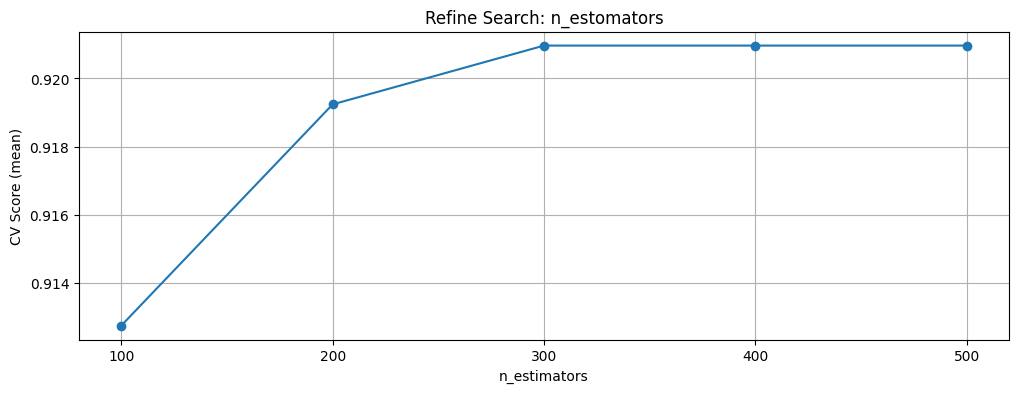

{'random_state': 42, 'n_jobs': -1, 'class_weight': 'balanced', 'n_estimators': 300}


In [32]:
param_range = list(range(100, 501, 100))

best_n, best_score = tune_param(
    param_name='n_estimators',
    param_values=param_range,
    fixed_params=fixed_params,
    x=under_x_train,
    y=under_y_train,
    title='Refine Search: n_estomators'
)

fixed_params['n_estimators'] = best_n
print(fixed_params)

Best n_estimators: 255, Best CV score: 0.9210


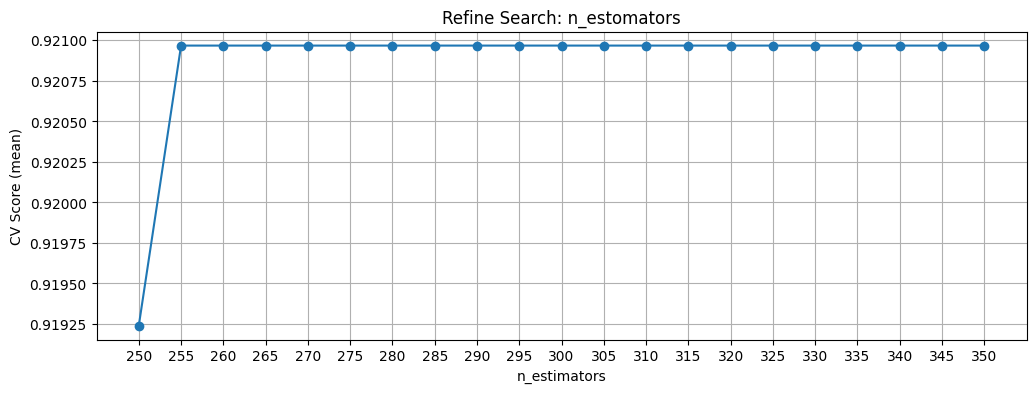

{'random_state': 42, 'n_jobs': -1, 'class_weight': 'balanced', 'n_estimators': 255}


In [33]:
param_range = list(range(best_n - 50, best_n + 51, 5))

best_n, best_score = tune_param(
    param_name='n_estimators',
    param_values=param_range,
    fixed_params=fixed_params,
    x=under_x_train,
    y=under_y_train,
    title='Refine Search: n_estomators'
)

fixed_params['n_estimators'] = best_n
print(fixed_params)

### max_depth

Best max_depth: 5, Best CV score: 0.9227


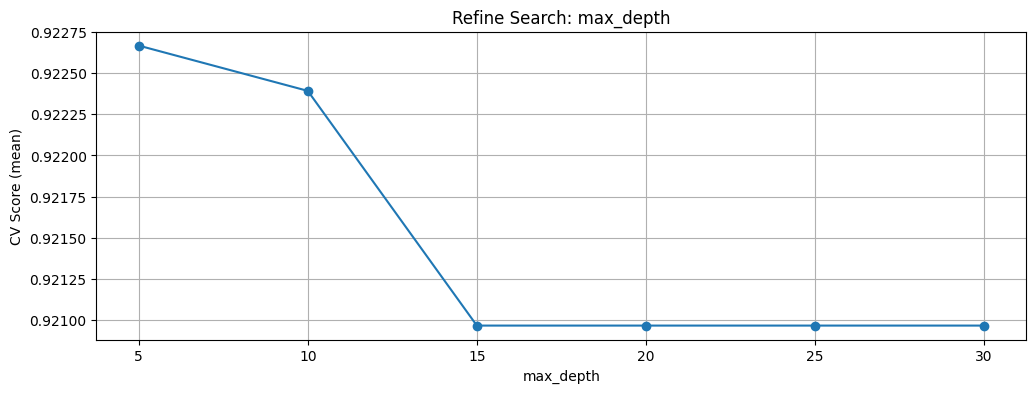

{'random_state': 42, 'n_jobs': -1, 'class_weight': 'balanced', 'n_estimators': 255, 'max_depth': 5}


In [34]:
param_range = list(range(5, 31, 5))

best_n, best_score = tune_param(
    param_name='max_depth',
    param_values=param_range,
    fixed_params=fixed_params,
    x=under_x_train,
    y=under_y_train,
    title='Refine Search: max_depth'
)

fixed_params['max_depth'] = best_n
print(fixed_params)

## 實際測試

In [35]:
print(fixed_params)

rf_model = RandomForestClassifier(**fixed_params)
rf_model.fit(x_train, y_train)

# predict and print result
y_pred = rf_model.predict(x_test)
# print(classification_report(y_test, y_pred))
evaluation(y_test, y_pred, model_name="Random Forest(Supervised)")

{'random_state': 42, 'n_jobs': -1, 'class_weight': 'balanced', 'n_estimators': 255, 'max_depth': 5}

Random Forest(Supervised) Evaluation:
         Accuracy: 0.9970857764825674
  Precision Score: 0.3426183844011142
     Recall Score: 0.9044117647058824
         F1 Score: 0.49696969696969695

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.34      0.90      0.50       136

    accuracy                           1.00     85443
   macro avg       0.67      0.95      0.75     85443
weighted avg       1.00      1.00      1.00     85443



### class_weight

In [36]:
class_weights_to_test = [
    'balanced',
    {0: 1, 1: 50},
    {0: 1, 1: 100},
    {0: 1, 1: 200},
    {0: 1, 1: 300},
    {0: 1, 1: 400},
    {0: 1, 1: 578}
]

best_f1_so_far = -1
best_cw_setting = None

for cw in class_weights_to_test:
    print(f"\n--- 測試 class_weight: {cw} ---")
    current_params = fixed_params.copy()
    current_params['class_weight'] = cw

    rf_model = RandomForestClassifier(**current_params)
    rf_model.fit(x_train, y_train) # 在 x_train 上訓練

    y_pred = rf_model.predict(x_test)
    
    current_f1 = f1_score(y_test, y_pred)
    print(f"使用 class_weight={cw} 時，測試集上的 F1-score: {current_f1:.4f}")
    evaluation(y_test, y_pred, model_name=f"Random Forest (class_weight={cw})")

    if current_f1 > best_f1_so_far:
        best_f1_so_far = current_f1
        best_cw_setting = cw

print(f"best class_weight: {best_cw_setting}，對應 F1: {best_f1_so_far:.4f}")


--- 測試 class_weight: balanced ---
使用 class_weight=balanced 時，測試集上的 F1-score: 0.4970

Random Forest (class_weight=balanced) Evaluation:
         Accuracy: 0.9970857764825674
  Precision Score: 0.3426183844011142
     Recall Score: 0.9044117647058824
         F1 Score: 0.49696969696969695

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.34      0.90      0.50       136

    accuracy                           1.00     85443
   macro avg       0.67      0.95      0.75     85443
weighted avg       1.00      1.00      1.00     85443


--- 測試 class_weight: {0: 1, 1: 50} ---
使用 class_weight={0: 1, 1: 50} 時，測試集上的 F1-score: 0.8387

Random Forest (class_weight={0: 1, 1: 50}) Evaluation:
         Accuracy: 0.9994733330992591
  Precision Score: 0.8181818181818182
     Recall Score: 0.8602941176470589
         F1 Score: 0.8387096774193549

Classification Report:
              precision    recall

In [37]:
fixed_params['class_weight'] = {0: 1, 1: 50}

In [38]:
print(fixed_params)

rf_model = RandomForestClassifier(**fixed_params)
rf_model.fit(x_train, y_train)

# predict and print result
y_pred = rf_model.predict(x_test)
# print(classification_report(y_test, y_pred))
evaluation(y_test, y_pred, model_name="Random Forest(Supervised)")

{'random_state': 42, 'n_jobs': -1, 'class_weight': {0: 1, 1: 50}, 'n_estimators': 255, 'max_depth': 5}

Random Forest(Supervised) Evaluation:
         Accuracy: 0.9994733330992591
  Precision Score: 0.8181818181818182
     Recall Score: 0.8602941176470589
         F1 Score: 0.8387096774193549

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.82      0.86      0.84       136

    accuracy                           1.00     85443
   macro avg       0.91      0.93      0.92     85443
weighted avg       1.00      1.00      1.00     85443



## 嘗試更換模型 (XGBoost)

In [46]:
from xgboost import XGBClassifier

In [47]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    # scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_SEED
)

xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [48]:
y_pred = xgb.predict(x_test)

evaluation(y_test, y_pred, model_name="XGBoost")


XGBoost + Isolation Forest Evaluation:
         Accuracy: 0.9996254813150287
  Precision Score: 0.9333333333333333
     Recall Score: 0.8235294117647058
         F1 Score: 0.875

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.88       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443

